INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ia91qr5/z7yb2m7c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ia91qr5/kby8hf7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48941', 'data', 'file=/tmp/tmp3ia91qr5/z7yb2m7c.json', 'init=/tmp/tmp3ia91qr5/kby8hf7s.json', 'output', 'file=/tmp/tmp3ia91qr5/prophet_model3zfql_7g/prophet_model-20250727154617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:46:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:46:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/tmp/ipython-input-1-1446602438.py:57: U

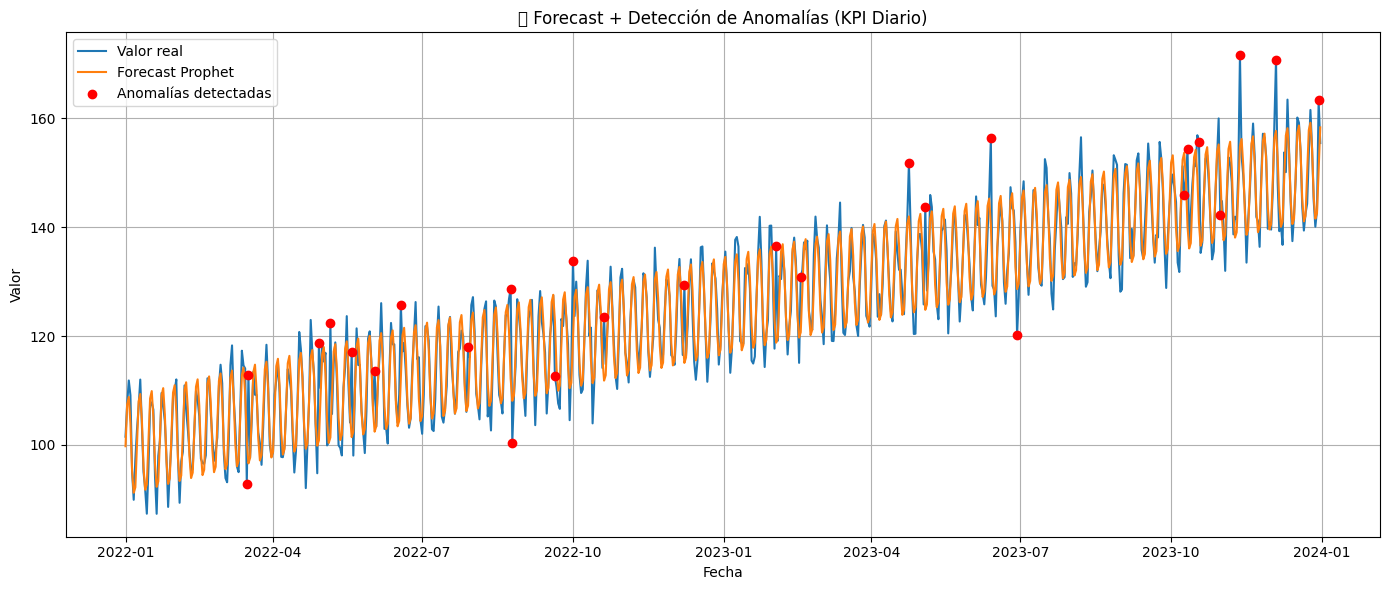

📌 MAE:  2.66
📌 RMSE: 3.84
🚨 Anomalías detectadas: 27


In [1]:
# ✅ 0. INSTALACIÓN (solo si usas Google Colab)
!pip install --quiet prophet

# 📦 1. IMPORTACIONES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ================================
# 2️⃣ SIMULACIÓN DE DATOS DE KPI DIARIO
# ================================
np.random.seed(42)
n_days = 730  # 2 años
dates = pd.date_range(start="2022-01-01", periods=n_days, freq='D')

# Composición del KPI
trend = np.linspace(100, 150, n_days)
seasonality = 10 * np.sin(2 * np.pi * np.arange(n_days) / 7)
noise = np.random.normal(0, 3, n_days)
spikes = np.random.choice([0, 15], size=n_days, p=[0.98, 0.02])  # anomalías

kpi = trend + seasonality + noise + spikes
df = pd.DataFrame({'ds': dates, 'y': kpi})

# ================================
# 3️⃣ FORECASTING CON PROPHET
# ================================
model = Prophet(weekly_seasonality=True)
model.fit(df)

future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)

# ================================
# 4️⃣ RESIDUALES + ANOMALÍAS
# ================================
df['yhat'] = forecast['yhat']
df['residual'] = df['y'] - df['yhat']
threshold = 2 * np.std(df['residual'])  # regla de 2 sigma
df['anomaly'] = np.abs(df['residual']) > threshold

# ================================
# 5️⃣ VISUALIZACIÓN
# ================================
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], label='Valor real', linewidth=1.5)
plt.plot(df['ds'], df['yhat'], label='Forecast Prophet', linewidth=1.5)
plt.scatter(df[df['anomaly']]['ds'], df[df['anomaly']]['y'],
            color='red', label='Anomalías detectadas', zorder=5)
plt.title("📊 Forecast + Detección de Anomalías (KPI Diario)")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ================================
# 6️⃣ MÉTRICAS DE FORECAST
# ================================
mae = mean_absolute_error(df['y'], df['yhat'])
rmse = np.sqrt(mean_squared_error(df['y'], df['yhat']))
n_anomalies = df['anomaly'].sum()

print(f"📌 MAE:  {mae:.2f}")
print(f"📌 RMSE: {rmse:.2f}")
print(f"🚨 Anomalías detectadas: {n_anomalies}")


/tmp/ipython-input-2-227681237.py:12: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


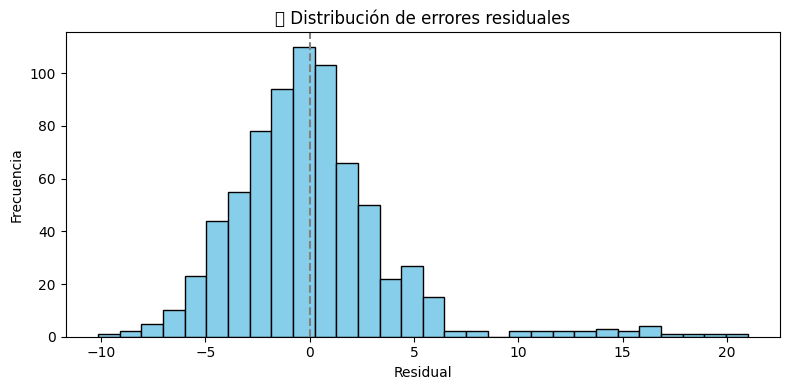

/tmp/ipython-input-2-227681237.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


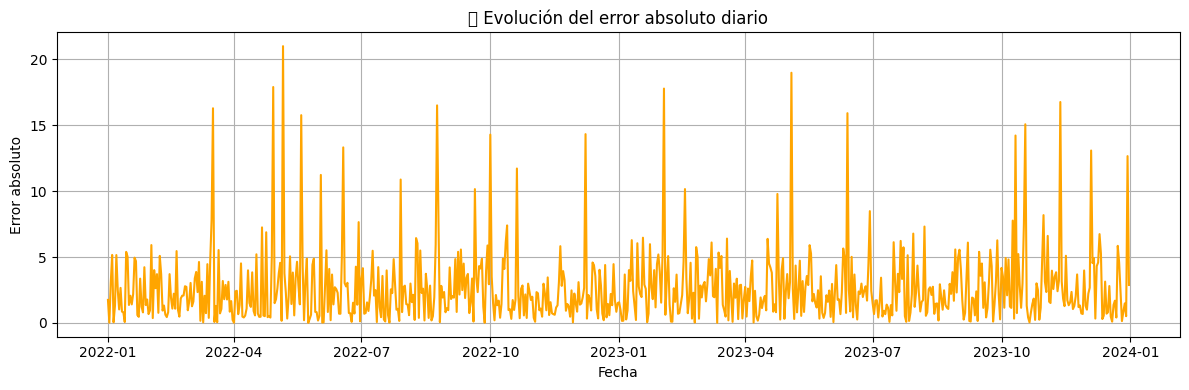

📌 MAPE (Error porcentual medio): 2.14%


/tmp/ipython-input-2-227681237.py:43: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


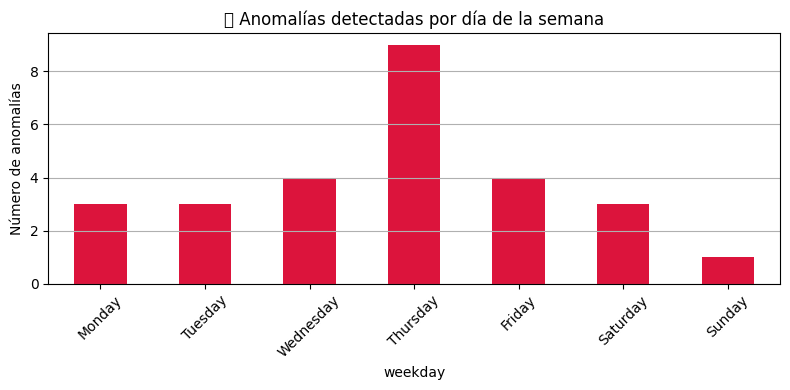

In [2]:
# ================================
# 🔍 Análisis avanzado de errores y anomalías
# ================================

# 1. Histograma de residuales
plt.figure(figsize=(8, 4))
plt.hist(df['residual'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(0, color='gray', linestyle='--')
plt.title("📉 Distribución de errores residuales")
plt.xlabel("Residual")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 2. Evolución del error absoluto
df['abs_error'] = np.abs(df['residual'])
plt.figure(figsize=(12, 4))
plt.plot(df['ds'], df['abs_error'], color='orange')
plt.title("📈 Evolución del error absoluto diario")
plt.xlabel("Fecha")
plt.ylabel("Error absoluto")
plt.tight_layout()
plt.grid(True)
plt.show()

# 3. MAPE
df['percentage_error'] = df['abs_error'] / df['y']
mape = df['percentage_error'].mean() * 100
print(f"📌 MAPE (Error porcentual medio): {mape:.2f}%")

# 4. Análisis temporal de anomalías
df['weekday'] = df['ds'].dt.day_name()
anomalies_by_day = df[df['anomaly']].groupby('weekday').size().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(8, 4))
anomalies_by_day.plot(kind='bar', color='crimson')
plt.title("🚨 Anomalías detectadas por día de la semana")
plt.ylabel("Número de anomalías")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
